Cargando datos...
DataFrame cargado: 1301 filas, 11 columnas
Rango de fechas: 2020-01-02 00:00:00 a 2025-04-29 00:00:00

Columnas disponibles:
['close_btc', 'volume_btc', 'date', 'close_WTI', 'volume_oil', 'close_vix', 'close_cpi', 'close_int', 'difficulty', 'hash_rate', 'value_fear_greed']

Renombrando columna 'close_btc' a 'close'

Creando variables para el modelo...

Distribución de señales:
Rojo (0): 533 (41.0%)
Amarillo (1): 193 (14.8%)
Verde (2): 575 (44.2%)

Creando características (features)...
DataFrame después de feature engineering: 1286 filas, 37 columnas

Dividiendo datos en train, validation y test...

División temporal:
Train: 907 filas (2020-01-23 00:00:00 a 2023-09-06 00:00:00)
Validation: 193 filas (2023-09-07 00:00:00 a 2024-06-14 00:00:00)
Test: 186 filas (2024-06-17 00:00:00 a 2025-03-26 00:00:00)

Lista de 33 características guardada en 'feature_list.pkl'

Entrenando y evaluando todos los modelos...

Entrenando: Random Forest
Fitting 5 folds for each of 24 candida

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Pytho

Modelo guardado como 'logistic_regression_model.pkl'

COMPARACIÓN DE MODELOS
Random Forest: F1 Score = 0.3634
Gradient Boosting: F1 Score = 0.3875
AdaBoost: F1 Score = 0.3413
XGBoost: F1 Score = 0.3901
Logistic Regression: F1 Score = 0.4306

Realizando análisis de backtest...
Análisis de backtest guardado como 'model_comparison_backtest.png'

Estadísticas de rendimiento:
                Modelo  F1 Score  Retorno Total (%)  Retorno Medio Diario (%)  \
0        Random Forest  0.363449         -44.441995                 -0.253545   
1    Gradient Boosting  0.387481          27.013144                  0.185976   
2             AdaBoost  0.341256         -48.484138                 -0.293536   
3              XGBoost  0.390083          -1.086237                  0.056199   
4  Logistic Regression  0.430606         117.672305                  0.478119   
5           Buy & Hold       NaN          41.761656                  0.248588   

   Volatilidad Diaria (%)  Ratio Sharpe  Max Drawdown (%) 

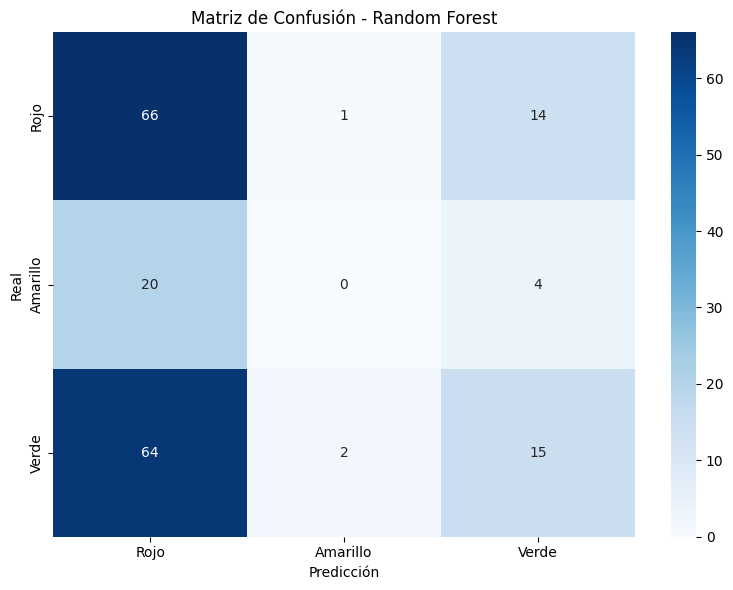

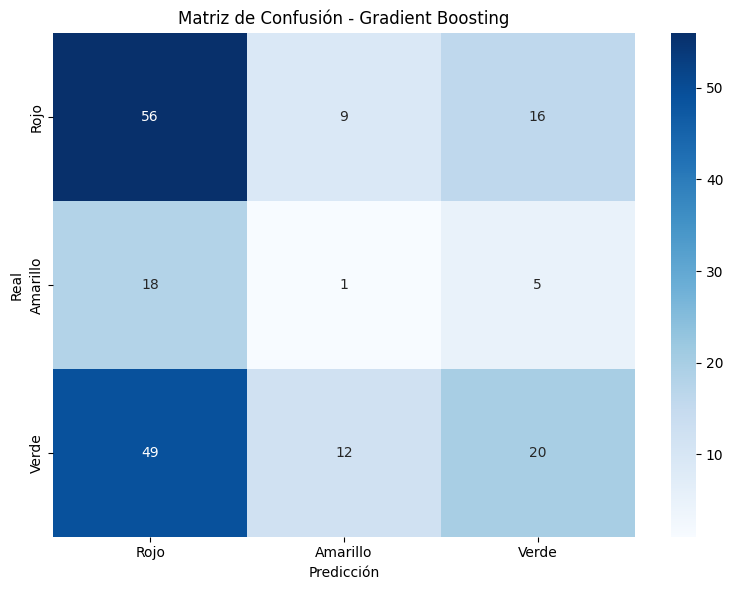

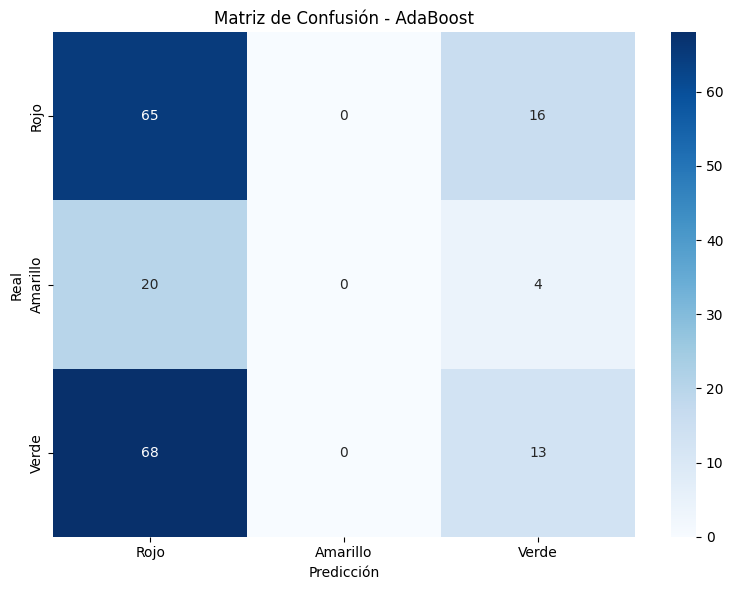

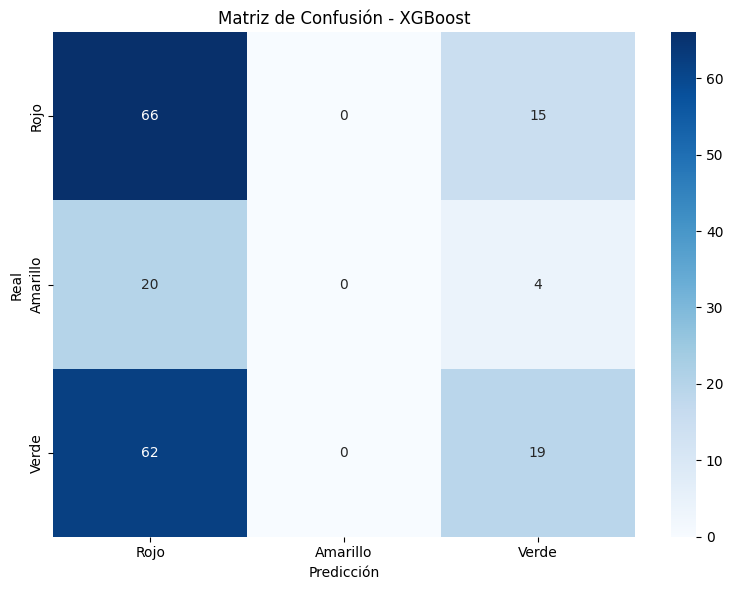

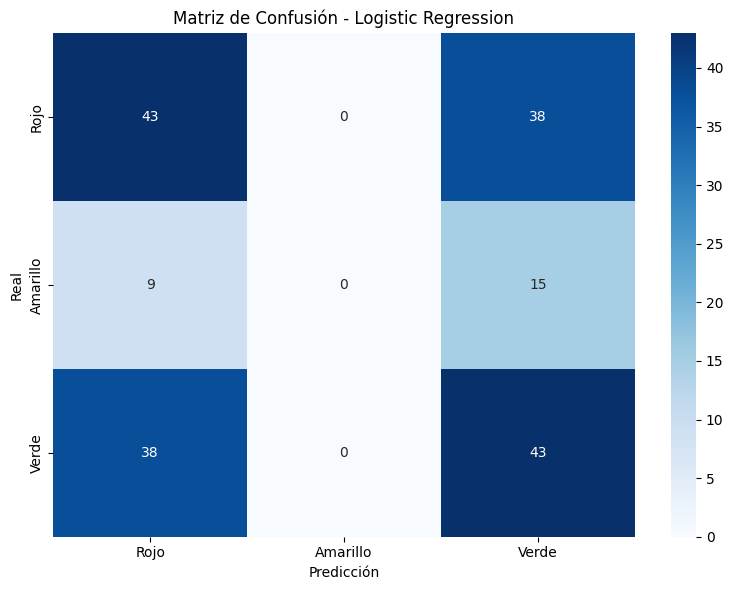

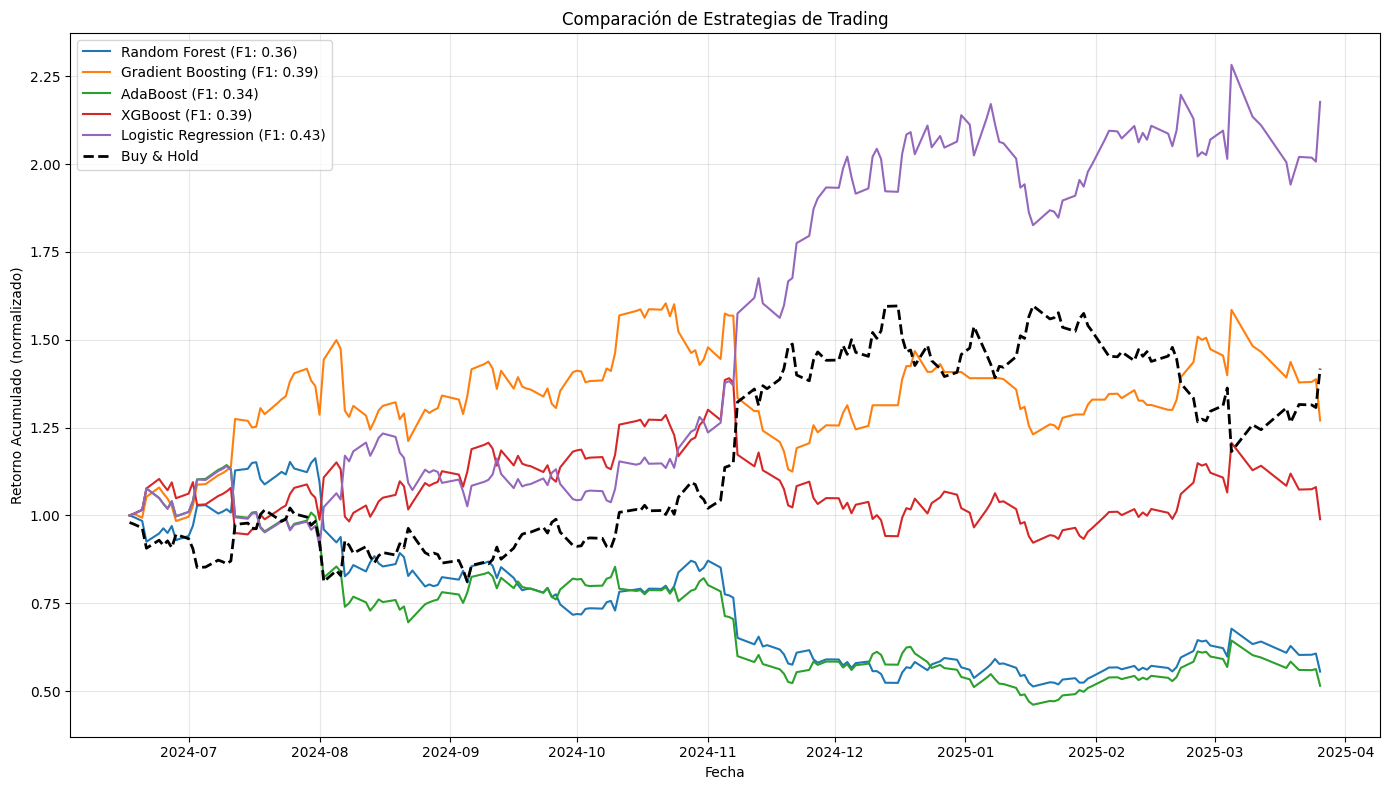

In [10]:
# Importar librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
try:
    import xgboost as xgb
    xgboost_available = True
except ImportError:
    print("XGBoost no está instalado.")
    xgboost_available = False
import pickle
import warnings
warnings.filterwarnings('ignore')

# 1. Cargar y preparar los datos
# ====================================
print("Cargando datos...")
df = pd.read_csv('data/merged_data.csv', parse_dates=['date'])
df.sort_values('date', inplace=True)

print(f"DataFrame cargado: {df.shape[0]} filas, {df.shape[1]} columnas")
print(f"Rango de fechas: {df['date'].min()} a {df['date'].max()}")

# Mostrar las columnas disponibles
print("\nColumnas disponibles:")
print(df.columns.tolist())

# Identificar automáticamente la columna de precio de Bitcoin
btc_columns = [col for col in df.columns if 'btc' in col.lower() and ('close' in col.lower() or 'price' in col.lower())]
if btc_columns:
    price_column = btc_columns[0]
elif 'close' in df.columns:
    price_column = 'close'
elif 'Price' in df.columns:
    price_column = 'Price'
else:
    # Buscar entre columnas numéricas
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if numeric_cols:
        price_column = numeric_cols[0]
        print(f"\nSeleccionando automáticamente '{price_column}' como columna de precio.")
    else:
        raise ValueError("No se encontraron columnas numéricas para usar como precio.")

# Renombrar a 'close' para el resto del código
if price_column != 'close':
    print(f"\nRenombrando columna '{price_column}' a 'close'")
    df = df.rename(columns={price_column: 'close'})
else:
    print("\nUsando columna 'close' existente")

# 2. Creación de variables objetivo y características
# ====================================
print("\nCreando variables para el modelo...")

# Definir umbral para clasificación
delta = 0.005  # 0.5%

# Calcular rendimiento del día siguiente
df['ret_t1'] = df['close'].shift(-1) / df['close'] - 1

# Función para clasificar en semáforo (usando 0, 1, 2 para compatibilidad con todos los modelos)
def semaforo(r, delta):
    if r >= delta:
        return 2    # Verde: sube más del umbral
    elif r <= -delta:
        return 0    # Rojo: baja más del umbral
    else:
        return 1    # Amarillo: se mueve dentro del rango lateral

# Función para convertir etiqueta numérica a texto (para uso en Streamlit)
def etiqueta_a_texto(label):
    if label == 2:
        return "Verde"
    elif label == 0:
        return "Rojo"
    else:
        return "Amarillo"

# Aplicar clasificación
df['Signal'] = df['ret_t1'].apply(lambda r: semaforo(r, delta))

# Eliminar filas sin etiqueta
df.dropna(subset=['Signal'], inplace=True)

# Visualizar distribución de señales
signal_counts = df['Signal'].value_counts()
print("\nDistribución de señales:")
print(f"Rojo (0): {signal_counts.get(0, 0)} ({signal_counts.get(0, 0)/len(df)*100:.1f}%)")
print(f"Amarillo (1): {signal_counts.get(1, 0)} ({signal_counts.get(1, 0)/len(df)*100:.1f}%)")
print(f"Verde (2): {signal_counts.get(2, 0)} ({signal_counts.get(2, 0)/len(df)*100:.1f}%)")

# 3. Feature Engineering - Crear características avanzadas
# ====================================
print("\nCreando características (features)...")

# a) Lags de rendimiento (usando shift correctamente)
for lag in [1, 2, 3]:
    df[f'ret_lag{lag}'] = df['ret_t1'].shift(lag)

# b) Medias móviles y características derivadas
for w in [3, 7, 14]:
    # Medias móviles de precio
    df[f'close_ma{w}'] = df['close'].rolling(w).mean()
    
    # Ratio precio/media móvil (indicador técnico importante)
    df[f'close_to_ma{w}'] = df['close'] / df[f'close_ma{w}']
    
    # Aplicar a otras columnas si existen
    if 'volume_btc' in df.columns:
        df[f'volume_btc_ma{w}'] = df['volume_btc'].rolling(w).mean()
    
    if 'hash_rate' in df.columns:
        df[f'hash_rate_ma{w}'] = df['hash_rate'].rolling(w).mean()
    
    if 'difficulty' in df.columns:
        df[f'difficulty_ma{w}'] = df['difficulty'].rolling(w).mean()
    
    if 'fear_greed' in df.columns:
        df[f'fear_greed_ma{w}'] = df['fear_greed'].rolling(w).mean()

# c) Volatilidad
df['volatility_7d'] = df['close'].pct_change().rolling(7).std()
df['volatility_14d'] = df['close'].pct_change().rolling(14).std()

# d) Momentum y tendencia
df['momentum_3d'] = df['close'].pct_change(3)
df['momentum_7d'] = df['close'].pct_change(7)

# e) Cruzamiento de medias móviles
df['ma_crossover'] = np.where(df['close_ma3'] > df['close_ma7'], 1, -1)

# f) Otras relaciones entre variables
available_columns = df.columns.tolist()
if 'vix' in available_columns:
    df['btc_vix_ratio'] = df['close'] / df['vix']

if all(col in available_columns for col in ['hash_rate', 'difficulty']):
    df['hash_diff_ratio'] = df['hash_rate'] / df['difficulty']

# Eliminar filas con datos faltantes
df.dropna(inplace=True)
print(f"DataFrame después de feature engineering: {df.shape[0]} filas, {df.shape[1]} columnas")

# 4. División temporal de los datos
# ====================================
print("\nDividiendo datos en train, validation y test...")

# Determinar fechas de corte según los datos disponibles
min_date = df['date'].min()
max_date = df['date'].max()
date_range = (max_date - min_date).days

# Adaptamos las fechas en función del rango disponible
if date_range >= 180:  # Si tenemos al menos 6 meses de datos
    fecha_fin_train = min_date + pd.Timedelta(days=int(date_range * 0.7))
    fecha_fin_val = min_date + pd.Timedelta(days=int(date_range * 0.85))
else:  # Para periodos más cortos
    fecha_fin_train = min_date + pd.Timedelta(days=int(date_range * 0.6))
    fecha_fin_val = min_date + pd.Timedelta(days=int(date_range * 0.8))

# División por fechas
train = df[df['date'] <= fecha_fin_train]
val = df[(df['date'] > fecha_fin_train) & (df['date'] <= fecha_fin_val)]
test = df[df['date'] > fecha_fin_val]

# Verificar que hay datos suficientes en cada conjunto
if len(train) < 30 or len(val) < 10 or len(test) < 10:
    print("\nADVERTENCIA: Conjunto de datos pequeño, ajustando división...")
    # División por índice para conjuntos pequeños
    train_size = int(0.7 * len(df))
    val_size = int(0.15 * len(df))
    
    train = df.iloc[:train_size]
    val = df.iloc[train_size:train_size+val_size]
    test = df.iloc[train_size+val_size:]
    
    fecha_fin_train = train['date'].max()
    fecha_fin_val = val['date'].max()

print(f"\nDivisión temporal:")
print(f"Train: {train.shape[0]} filas ({train['date'].min()} a {train['date'].max()})")
print(f"Validation: {val.shape[0]} filas ({val['date'].min()} a {val['date'].max()})")
print(f"Test: {test.shape[0]} filas ({test['date'].min()} a {test['date'].max()})")

# 5. Preparar los datos para los modelos
# ====================================
feature_cols = [col for col in df.columns 
                if col not in ['date', 'close', 'ret_t1', 'Signal']]

# Guardar lista de características para uso futuro en Streamlit
feature_list = feature_cols.copy()
pickle.dump(feature_list, open('feature_list.pkl', 'wb'))
print(f"\nLista de {len(feature_cols)} características guardada en 'feature_list.pkl'")

# Separar X e y para cada conjunto
X_train, y_train = train[feature_cols], train['Signal']
X_val, y_val = val[feature_cols], val['Signal']
X_test, y_test = test[feature_cols], test['Signal']

# 6. Definición y entrenamiento de los 5 modelos
# ====================================

# Función para entrenar y evaluar un modelo con manejo de errores
def train_evaluate_model(pipe, params, model_name):
    """Entrena y evalúa un modelo con búsqueda de hiperparámetros"""
    print(f"\n{'='*50}")
    print(f"Entrenando: {model_name}")
    print(f"{'='*50}")
    
    try:
        # Validación en series temporales
        tscv = TimeSeriesSplit(n_splits=5)
        
        # Búsqueda de hiperparámetros
        grid = GridSearchCV(
            pipe, params, cv=tscv, scoring='f1_weighted', 
            n_jobs=-1, verbose=1
        )
        
        grid.fit(X_train, y_train)
        
        print(f"Mejor puntuación CV: {grid.best_score_:.4f}")
        print(f"Mejores parámetros: {grid.best_params_}")
        
        # Evaluar en conjunto de validación
        model = grid.best_estimator_
        y_val_pred = model.predict(X_val)
        val_f1 = f1_score(y_val, y_val_pred, average='weighted')
        
        # Reentrenar con train + val para evaluación final
        X_train_val = pd.concat([X_train, X_val])
        y_train_val = pd.concat([y_train, y_val])
        
        final_model = grid.best_estimator_
        final_model.fit(X_train_val, y_train_val)
        
        # Evaluar en conjunto de test
        y_test_pred = final_model.predict(X_test)
        test_f1 = f1_score(y_test, y_test_pred, average='weighted')
        
        print(f"\nRendimiento en test:")
        print(classification_report(y_test, y_test_pred, target_names=['Rojo', 'Amarillo', 'Verde']))
        
        # Matriz de confusión
        cm = confusion_matrix(y_test, y_test_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Rojo', 'Amarillo', 'Verde'],
                    yticklabels=['Rojo', 'Amarillo', 'Verde'])
        plt.xlabel('Predicción')
        plt.ylabel('Real')
        plt.title(f'Matriz de Confusión - {model_name}')
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{model_name.replace(" ", "_").lower()}.png')
        
        # Guardar modelo en formato para Streamlit
        model_info = {
            'model': final_model,
            'feature_list': feature_cols,
            'class_labels': {0: 'Rojo', 1: 'Amarillo', 2: 'Verde'},
            'date_trained': pd.Timestamp.now().strftime("%Y-%m-%d"),
            'f1_score': test_f1,
            'description': f"Modelo {model_name} entrenado en datos desde {min_date.strftime('%Y-%m-%d')} hasta {max_date.strftime('%Y-%m-%d')}"
        }
        
        pickle.dump(model_info, open(f'{model_name.replace(" ", "_").lower()}_model.pkl', 'wb'))
        print(f"Modelo guardado como '{model_name.replace(' ', '_').lower()}_model.pkl'")
        
        # Resultados para análisis de backtest
        results = test[['date', 'close', 'ret_t1', 'Signal']].copy()
        results['prediction'] = y_test_pred
        
        # Para backtest: Rojo (0) -> -1, Amarillo (1) -> 0, Verde (2) -> 1
        strategy_map = {0: -1, 1: 0, 2: 1} 
        results['prediction_strategy'] = results['prediction'].map(strategy_map)
        
        return final_model, test_f1, results
    
    except Exception as e:
        print(f"Error al entrenar modelo {model_name}: {str(e)}")
        return None, 0, None

# Configuración de los 5 modelos a comparar
# =========================================

# 1. Random Forest
rf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(f_classif)),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_params = {
    'feature_selection__k': [min(5, len(feature_cols) - 1), 
                            min(10, len(feature_cols) - 1)],
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, None],
    'classifier__class_weight': ['balanced', 'balanced_subsample']
}

# 2. Gradient Boosting
gb_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(f_classif)),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

gb_params = {
    'feature_selection__k': [min(5, len(feature_cols) - 1), 
                           min(10, len(feature_cols) - 1)],
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.05, 0.1]
}

# 3. AdaBoost
ada_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(f_classif)),
    ('classifier', AdaBoostClassifier(random_state=42))
])

ada_params = {
    'feature_selection__k': [min(5, len(feature_cols) - 1), 
                           min(10, len(feature_cols) - 1)],
    'classifier__n_estimators': [50, 100],
    'classifier__learning_rate': [0.1, 1.0]
}

# 4. XGBoost o SVC
if xgboost_available:
    xgb_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(f_classif)),
        ('classifier', xgb.XGBClassifier(random_state=42))
    ])
    
    xgb_params = {
        'feature_selection__k': [min(5, len(feature_cols) - 1), 
                               min(10, len(feature_cols) - 1)],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 5],
        'classifier__learning_rate': [0.05, 0.1]
    }
    model_name4 = "XGBoost"
else:
    # Si XGBoost no está disponible, usamos SVC
    xgb_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(f_classif)),
        ('classifier', SVC(probability=True, random_state=42))
    ])
    
    xgb_params = {
        'feature_selection__k': [min(5, len(feature_cols) - 1), 
                               min(10, len(feature_cols) - 1)],
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__gamma': ['scale', 'auto'],
        'classifier__class_weight': ['balanced', None]
    }
    model_name4 = "SVC"

# 5. Logistic Regression
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(f_classif)),
    ('classifier', LogisticRegression(multi_class='multinomial', 
                                     solver='lbfgs', max_iter=2000, 
                                     random_state=42))
])

lr_params = {
    'feature_selection__k': [min(5, len(feature_cols) - 1), 
                           min(10, len(feature_cols) - 1)],
    'classifier__C': [0.01, 0.1, 1.0],
    'classifier__class_weight': ['balanced', None]
}

# Configurar diccionario de modelos
models = {
    'Random Forest': (rf_pipe, rf_params),
    'Gradient Boosting': (gb_pipe, gb_params),
    'AdaBoost': (ada_pipe, ada_params),
    model_name4: (xgb_pipe, xgb_params),
    'Logistic Regression': (lr_pipe, lr_params)
}

# 7. Entrenar y evaluar todos los modelos
print("\nEntrenando y evaluando todos los modelos...")
results_dict = {}

for name, (pipe, params) in models.items():
    model, score, model_results = train_evaluate_model(pipe, params, name)
    if model is not None:  # Solo añadir modelos que se entrenaron correctamente
        results_dict[name] = {
            'model': model,
            'score': score,
            'results': model_results
        }

# 8. Comparar rendimiento de todos los modelos
print("\n" + "="*50)
print("COMPARACIÓN DE MODELOS")
print("="*50)

# Tabla de métricas
for name, results in results_dict.items():
    print(f"{name}: F1 Score = {results['score']:.4f}")

# 9. Análisis de backtest (rentabilidad)
print("\nRealizando análisis de backtest...")
# Inicializar DataFrame para backtest
backtest_results = pd.DataFrame({'date': test['date'].reset_index(drop=True)})
backtest_results['close'] = test['close'].reset_index(drop=True)
backtest_results['actual_return'] = test['ret_t1'].reset_index(drop=True)

# Calcular estrategia para cada modelo
for name, results in results_dict.items():
    # Obtener predicciones
    model_results = results['results']
    
    # Añadir predicciones al DataFrame de backtest (usar el valor de estrategia para trading)
    backtest_results[f'{name}_pred'] = model_results['prediction_strategy'].reset_index(drop=True)
    
    # Calcular posición basada en predicción del día anterior
    backtest_results[f'{name}_position'] = backtest_results[f'{name}_pred'].shift(1)
    backtest_results[f'{name}_position'].fillna(0, inplace=True)
    
    # Calcular retornos de la estrategia
    backtest_results[f'{name}_return'] = backtest_results[f'{name}_position'] * backtest_results['actual_return']
    
    # Calcular retorno acumulado
    backtest_results[f'{name}_cumulative'] = (1 + backtest_results[f'{name}_return']).cumprod()

# Calcular Buy & Hold como benchmark
backtest_results['BuyHold_cumulative'] = (1 + backtest_results['actual_return']).cumprod()

# Visualizar resultados de backtest
plt.figure(figsize=(14, 8))

# Graficar cada modelo
for name in results_dict.keys():
    plt.plot(backtest_results['date'], 
             backtest_results[f'{name}_cumulative'], 
             label=f"{name} (F1: {results_dict[name]['score']:.2f})")

# Graficar Buy & Hold
plt.plot(backtest_results['date'], 
         backtest_results['BuyHold_cumulative'], 
         'k--', linewidth=2, label='Buy & Hold')

plt.title('Comparación de Estrategias de Trading')
plt.xlabel('Fecha')
plt.ylabel('Retorno Acumulado (normalizado)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('model_comparison_backtest.png')

print("Análisis de backtest guardado como 'model_comparison_backtest.png'")

# 10. Análisis estadístico final
model_stats = []

for name in results_dict.keys():
    returns = backtest_results[f'{name}_return'].dropna()
    
    stats = {
        'Modelo': name,
        'F1 Score': results_dict[name]['score'],
        'Retorno Total (%)': (backtest_results[f'{name}_cumulative'].iloc[-1] - 1) * 100,
        'Retorno Medio Diario (%)': returns.mean() * 100,
        'Volatilidad Diaria (%)': returns.std() * 100,
        'Ratio Sharpe': (returns.mean() / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0,
        'Max Drawdown (%)': (1 - (backtest_results[f'{name}_cumulative'] / 
                           backtest_results[f'{name}_cumulative'].cummax())).max() * 100
    }
    model_stats.append(stats)

# Añadir Buy & Hold como benchmark
buyhold_returns = backtest_results['actual_return'].dropna()
buyhold_stats = {
    'Modelo': 'Buy & Hold',
    'F1 Score': np.nan,
    'Retorno Total (%)': (backtest_results['BuyHold_cumulative'].iloc[-1] - 1) * 100,
    'Retorno Medio Diario (%)': buyhold_returns.mean() * 100,
    'Volatilidad Diaria (%)': buyhold_returns.std() * 100,
    'Ratio Sharpe': (buyhold_returns.mean() / buyhold_returns.std()) * np.sqrt(252) if buyhold_returns.std() > 0 else 0,
    'Max Drawdown (%)': (1 - (backtest_results['BuyHold_cumulative'] / 
                           backtest_results['BuyHold_cumulative'].cummax())).max() * 100
}
model_stats.append(buyhold_stats)

# Crear DataFrame con estadísticas
stats_df = pd.DataFrame(model_stats)
print("\nEstadísticas de rendimiento:")
print(stats_df)

# Guardar estadísticas
stats_df.to_csv('model_performance_stats.csv', index=False)
print("Estadísticas guardadas en 'model_performance_stats.csv'")

# 11. Identificar el mejor modelo para Streamlit
# =================================================
print("\nSeleccionando el mejor modelo para implementar en Streamlit...")

# Ordenar modelos por F1 Score
best_models = sorted(results_dict.items(), key=lambda x: x[1]['score'], reverse=True)

if len(best_models) > 0:
    best_model_name, best_model_info = best_models[0]
    best_model = best_model_info['model']
    best_f1 = best_model_info['score']
    
    print(f"\nMejor modelo: {best_model_name} con F1 Score = {best_f1:.4f}")
    
    # Guardar una copia del mejor modelo específicamente para Streamlit
    best_model_info = {
        'model': best_model,
        'name': best_model_name,
        'feature_list': feature_cols,
        'class_labels': {0: 'Rojo', 1: 'Amarillo', 2: 'Verde'},
        'date_trained': pd.Timestamp.now().strftime("%Y-%m-%d"),
        'f1_score': best_f1,
        'description': f"Modelo {best_model_name} entrenado en datos desde {min_date.strftime('%Y-%m-%d')} hasta {max_date.strftime('%Y-%m-%d')}"
    }
    
    pickle.dump(best_model_info, open('best_model_for_streamlit.pkl', 'wb'))
    print(f"Mejor modelo guardado como 'best_model_for_streamlit.pkl'")
    
    # Función de ejemplo para usar en Streamlit
    def predict_tomorrow(model_info, latest_data):
        """
        Función que simula cómo se usará el modelo en Streamlit para predecir
        si mañana será Rojo, Amarillo o Verde.
        
        Args:
            model_info: Diccionario con el modelo y metadatos
            latest_data: DataFrame con los datos más recientes
            
        Returns:
            String con la predicción (Rojo, Amarillo o Verde)
        """
        # Extraer modelo y lista de características
        model = model_info['model']
        features = model_info['feature_list']
        class_labels = model_info['class_labels']
        
        # Preparar datos para predicción
        X = latest_data[features].values.reshape(1, -1)
        
        # Hacer predicción
        prediction = model.predict(X)[0]
        
        # Convertir a etiqueta de color
        color = class_labels[prediction]
        
        return color
    
    print("\n¡Análisis completo! Modelos entrenados y evaluados correctamente.")
    print("El mejor modelo está listo para ser implementado en Streamlit.")
else:
    print("\nAdvertencia: No se pudieron entrenar modelos correctamente. Revise los errores.")